In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import itertools
import matplotlib.pyplot as plt

https://www.kaggle.com/ouwyukha/copy-of-predict-movie-ratings/code

In [2]:
df_train = pd.read_csv('split_train.csv')

In [3]:
df_train.head()

,Unnamed: 0,userId,movieId,rating,encoded_user,encoded_movie
0,92857,599,551,3.5,598,483
1,82226,522,541,2.5,521,474
2,86691,561,1485,3.0,560,1134
3,96979,603,4232,1.0,602,3140
4,45140,298,58047,2.5,297,6665


In [4]:
df_train.movieId.nunique()

8980

<AxesSubplot:>

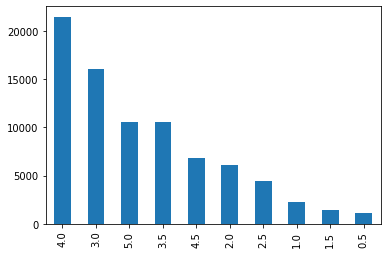

In [5]:
df_train.rating.value_counts().plot.bar()

### Dataset class

In [6]:
class MovieDataset:
    
    def __init__(self, user, movie, rating=None):
        self.user = user
        self.movie = movie
        self.rating = rating
        
    def __len__(self):
        return len(self.user)
    
    def __getitem__(self, item):
        
        user = self.user[item]
        movie = self.movie[item]
        
        if self.rating is not None:
            rating = self.rating[item]
            return {
                'user': torch.tensor(user, dtype=torch.long),
                'movie': torch.tensor(movie, dtype=torch.long),
                'rating': torch.tensor(rating, dtype=torch.float),
            }
        else:
             return {
                'user': torch.tensor(user, dtype=torch.long),
                'movie': torch.tensor(movie, dtype=torch.long),
            }

In [7]:
train_dataset = MovieDataset(df_train.encoded_user.values, df_train.encoded_movie.values, df_train.rating.values)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4096, shuffle=True)

### Model definition

In [8]:
class Predictor(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        
        self.lin1 = nn.Linear(2*in_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, 1, bias=False)
        
    def forward(self, user_feat, movie_feat):
        feats = torch.cat([user_feat, movie_feat], dim=1)
        
        h = F.relu(self.lin1(feats))
        h = self.lin2(h)
        
        return h

### Train loop

In [9]:
def train(model, user_feat, movie_feat, loader, criterion, optim, device):
    model.train()
    
    fin_loss = 0
    
    for data in tqdm.tqdm(loader, total=len(loader)):
        
        optim.zero_grad()
        logits = model(user_feat(data['user'].to(device)), movie_feat(data['movie'].to(device)))
        
        _loss = criterion(logits, data['rating'].to(device).view(-1,1))
        _loss.backward()
        
        optim.step()
        fin_loss += _loss.item()
        
    return fin_loss / len(loader)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
df = pd.read_csv('data_small/ratings.csv')

In [12]:
EPOCHS = 100
emb_size=64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Predictor(64, 32).to(device)
user_feat = nn.Embedding(df.userId.nunique(), emb_size, device=device)
movie_feat = nn.Embedding(df.movieId.nunique(), emb_size,device=device)

criterion =nn.MSELoss()
optim = torch.optim.Adam(itertools.chain(
                                         model.parameters(),
                                         user_feat.parameters(),
                                         movie_feat.parameters()),
                         lr=3e-4)

In [13]:
for e in range(EPOCHS):
    epoch_loss = train(model, user_feat, movie_feat, train_loader, criterion, optim, device)
    
    print(f"Epoch {e+1} - MSE: {epoch_loss}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 16.70it/s]


Epoch 1 - MSE: 12.677686309814453


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.49it/s]


Epoch 2 - MSE: 11.66576108932495


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 21.52it/s]


Epoch 3 - MSE: 10.693669366836549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.98it/s]


Epoch 4 - MSE: 9.734798383712768


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 21.83it/s]


Epoch 5 - MSE: 8.782440805435181


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.81it/s]


Epoch 6 - MSE: 7.83521568775177


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 21.81it/s]


Epoch 7 - MSE: 6.912936353683472


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 21.57it/s]


Epoch 8 - MSE: 6.031678485870361


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.98it/s]


Epoch 9 - MSE: 5.223188638687134


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.02it/s]


Epoch 10 - MSE: 4.5092003583908085


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.12it/s]


Epoch 11 - MSE: 3.906755268573761


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.92it/s]


Epoch 12 - MSE: 3.417563998699188


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.94it/s]


Epoch 13 - MSE: 3.028135025501251


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.37it/s]


Epoch 14 - MSE: 2.7167777538299562


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.24it/s]


Epoch 15 - MSE: 2.4661668062210085


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.31it/s]


Epoch 16 - MSE: 2.2580984115600584


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.23it/s]


Epoch 17 - MSE: 2.0866026103496553


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.43it/s]


Epoch 18 - MSE: 1.9411007702350616


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.19it/s]


Epoch 19 - MSE: 1.815274840593338


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.26it/s]


Epoch 20 - MSE: 1.7087751805782319


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.28it/s]


Epoch 21 - MSE: 1.6155503511428833


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.60it/s]


Epoch 22 - MSE: 1.5363918662071228


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.94it/s]


Epoch 23 - MSE: 1.4668301701545716


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.46it/s]


Epoch 24 - MSE: 1.4061120688915252


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.14it/s]


Epoch 25 - MSE: 1.3539887428283692


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.24it/s]


Epoch 26 - MSE: 1.3077175974845887


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.26it/s]


Epoch 27 - MSE: 1.2670187771320343


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.01it/s]


Epoch 28 - MSE: 1.2308399021625518


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.38it/s]


Epoch 29 - MSE: 1.1992080628871917


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.94it/s]


Epoch 30 - MSE: 1.1704594612121582


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.85it/s]


Epoch 31 - MSE: 1.1440936982631684


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.99it/s]


Epoch 32 - MSE: 1.1212020337581634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.32it/s]


Epoch 33 - MSE: 1.0998926401138305


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.67it/s]


Epoch 34 - MSE: 1.0808995246887207


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.23it/s]


Epoch 35 - MSE: 1.063109713792801


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.95it/s]


Epoch 36 - MSE: 1.046836283802986


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.49it/s]


Epoch 37 - MSE: 1.0325576186180114


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.58it/s]


Epoch 38 - MSE: 1.0186543107032775


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.69it/s]


Epoch 39 - MSE: 1.0049820482730865


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.53it/s]


Epoch 40 - MSE: 0.9929732650518417


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.70it/s]


Epoch 41 - MSE: 0.9820256173610687


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.08it/s]


Epoch 42 - MSE: 0.9712002575397491


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.72it/s]


Epoch 43 - MSE: 0.9606535583734512


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.83it/s]


Epoch 44 - MSE: 0.9510119020938873


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.64it/s]


Epoch 45 - MSE: 0.9415208727121354


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.10it/s]


Epoch 46 - MSE: 0.9329429268836975


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.69it/s]


Epoch 47 - MSE: 0.9250912666320801


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.92it/s]


Epoch 48 - MSE: 0.9163531601428986


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.04it/s]


Epoch 49 - MSE: 0.9085683137178421


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.41it/s]


Epoch 50 - MSE: 0.9013944536447525


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.88it/s]


Epoch 51 - MSE: 0.8942238062620163


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.83it/s]


Epoch 52 - MSE: 0.8870161801576615


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.06it/s]


Epoch 53 - MSE: 0.8801630824804306


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.70it/s]


Epoch 54 - MSE: 0.8742566615343094


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.15it/s]


Epoch 55 - MSE: 0.8670310705900193


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.69it/s]


Epoch 56 - MSE: 0.8614755123853683


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.55it/s]


Epoch 57 - MSE: 0.8557935029268264


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.53it/s]


Epoch 58 - MSE: 0.8491567015647888


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.28it/s]


Epoch 59 - MSE: 0.8438808232545852


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.62it/s]


Epoch 60 - MSE: 0.8385678619146347


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.33it/s]


Epoch 61 - MSE: 0.8342847019433975


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.41it/s]


Epoch 62 - MSE: 0.8280014753341675


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.21it/s]


Epoch 63 - MSE: 0.8233813762664794


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.58it/s]


Epoch 64 - MSE: 0.8187654614448547


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.57it/s]


Epoch 65 - MSE: 0.8129981368780136


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.92it/s]


Epoch 66 - MSE: 0.809560376405716


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.47it/s]


Epoch 67 - MSE: 0.8051555663347244


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.94it/s]


Epoch 68 - MSE: 0.8000197142362595


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.79it/s]


Epoch 69 - MSE: 0.7961693078279495


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.43it/s]


Epoch 70 - MSE: 0.7916310608386994


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.55it/s]


Epoch 71 - MSE: 0.7877644717693328


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.45it/s]


Epoch 72 - MSE: 0.7834243208169938


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.33it/s]


Epoch 73 - MSE: 0.7803838878870011


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.29it/s]


Epoch 74 - MSE: 0.7759557783603668


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.70it/s]


Epoch 75 - MSE: 0.7719468802213669


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.69it/s]


Epoch 76 - MSE: 0.7683809697628021


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.68it/s]


Epoch 77 - MSE: 0.7652908682823181


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.17it/s]


Epoch 78 - MSE: 0.7612416476011277


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.74it/s]


Epoch 79 - MSE: 0.7578358232975007


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.77it/s]


Epoch 80 - MSE: 0.7547382205724716


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.69it/s]


Epoch 81 - MSE: 0.7513857543468475


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.32it/s]


Epoch 82 - MSE: 0.7485795557498932


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.38it/s]


Epoch 83 - MSE: 0.7445439219474792


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.46it/s]


Epoch 84 - MSE: 0.7410723447799683


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.12it/s]


Epoch 85 - MSE: 0.739222115278244


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.76it/s]


Epoch 86 - MSE: 0.7359501034021377


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.92it/s]


Epoch 87 - MSE: 0.7329026311635971


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.74it/s]


Epoch 88 - MSE: 0.7295396715402603


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.45it/s]


Epoch 89 - MSE: 0.7263239711523056


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.99it/s]


Epoch 90 - MSE: 0.7238370805978775


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.55it/s]


Epoch 91 - MSE: 0.7208427667617798


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.57it/s]


Epoch 92 - MSE: 0.7182636946439743


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 20.00it/s]


Epoch 93 - MSE: 0.7156058698892593


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.95it/s]


Epoch 94 - MSE: 0.7128425687551498


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.47it/s]


Epoch 95 - MSE: 0.7100167989730835


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.62it/s]


Epoch 96 - MSE: 0.7076243162155151


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.08it/s]


Epoch 97 - MSE: 0.7047203332185745


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.21it/s]


Epoch 98 - MSE: 0.7027534008026123


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.94it/s]


Epoch 99 - MSE: 0.700094410777092


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.76it/s]

Epoch 100 - MSE: 0.6968106865882874


In [14]:
torch.save(model, 'nn predictor/model.pt')
torch.save(user_feat, 'nn predictor/user_embeddings.pt')
torch.save(movie_feat, 'nn predictor/movie_embeddings.pt')

---

### Predictions

#### Val dataset

In [15]:
df_val = pd.read_csv('split_val.csv')

In [16]:
val_dataset = MovieDataset(df_val.encoded_user.values, df_val.encoded_movie.values, df_val.rating.values)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4096, shuffle=False)

In [17]:
def validate(model, user_feat, movie_feat, loader, criterion, device):
    model.train()
    
    fin_loss = 0
    predictions = []
    ratings = []
    
    for data in tqdm.tqdm(loader, total=len(loader)):
        with torch.no_grad():
            logits = model(user_feat(data['user'].to(device)), movie_feat(data['movie'].to(device)))
            _loss = criterion(logits, data['rating'].to(device).view(-1,1))
    
            fin_loss += _loss.item()
            predictions.append(logits.cpu())
            ratings.append(data['rating'])
        
    return fin_loss / len(loader), torch.cat(predictions, dim=0).squeeze(1), torch.cat(ratings, dim=0)

In [18]:
mse_loss, predictions, ratings = validate(model, user_feat, movie_feat, val_loader, criterion, device)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.02it/s]


In [19]:
mse_loss

0.8570459127426148

In [30]:
predictions = torch.clamp(predictions, min=0, max=5)

In [31]:
df_predictions = pd.DataFrame({'rating': ratings, 
                               'prediction': predictions, 
                               'mse_loss':F.mse_loss(predictions , ratings, reduction='none')})

In [32]:
df_predictions.head()

,rating,prediction,mse_loss
0,4.0,3.933356,0.004441
1,4.0,3.848872,0.022840
2,2.5,3.175856,0.456781
3,5.0,3.607253,1.939745
4,5.0,4.140953,0.737962


#### Distribution plots

<AxesSubplot:title={'center':'Original rating distribution'}, xlabel='Rating', ylabel='Frequency'>

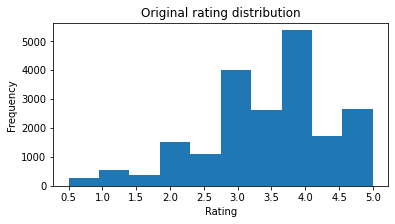

In [41]:
plt.figure(figsize=(6,3))
plt.title('Original rating distribution')
plt.xlabel('Rating')
plt.xticks(np.arange(0, 6, 0.5))
df_predictions.rating.plot.hist()

<AxesSubplot:title={'center':'MLP rating distribution'}, xlabel='Rating', ylabel='Frequency'>

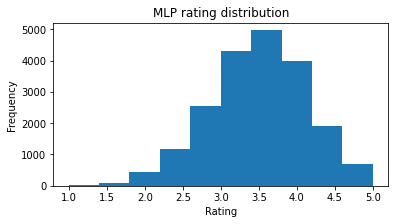

In [38]:
plt.figure(figsize=(6,3))
plt.title('MLP rating distribution')
plt.xlabel('Rating')
plt.xticks(np.arange(0, 6, 0.5))
df_predictions.prediction.plot.hist(bins=10)

<AxesSubplot:title={'center':'MSE Loss distribution'}, xlabel='mse', ylabel='Frequency'>

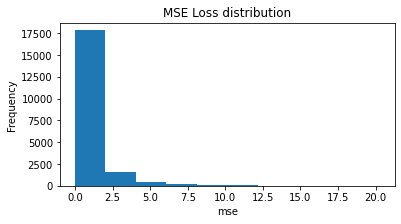

In [39]:
plt.figure(figsize=(6,3))
plt.title('MSE Loss distribution')
plt.xlabel('mse')
df_predictions.mse_loss.plot.hist()

#### Test data

In [37]:
def test(model, user_feat, movie_feat, loader, criterion, device):
    model.train()
    
    predictions = []
    
    for data in tqdm.tqdm(loader, total=len(loader)):
        with torch.no_grad():
            logits = model(user_feat(data['user'].to(device)), movie_feat(data['movie'].to(device)))
            predictions.append(logits.cpu())
        
    return torch.cat(predictions, dim=0).squeeze(1)

In [ ]:
df_test = pd.read_csv('data/test.csv')

In [ ]:
df_test['encoded_user']=encoders['user'].fit_transform(df_test['user'])
df_test['encoded_movie']=encoders['movie'].fit_transform(df_test['movie'])

In [ ]:
test_dataset = MovieDataset(df_test.encoded_user.values, df_test.encoded_movie.values)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4096, shuffle=False)

In [ ]:
predictions = test(model, user_feat, movie_feat, test_loader, criterion, device)

In [ ]:
df_test.drop(columns=['timestamp', 'encoded_user', 'encoded_movie'], inplace=True)

In [ ]:
df_test['nn_prediction'] = predictions

In [ ]:
df_test.to_csv('vainilla nn artifacts/vainilla_nn_predictions.csv')